In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import os
import nltk as nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pycaret as pc
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model 
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import hvplot.pandas
import plotly.express as px
import datetime as dt
from pandas_profiling import ProfileReport
import seaborn  as sns
import spacy
import gensim
import plotly.graph_objects as go
import textblob   
import textstat
import pyLDAvis

from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame


In [3]:
!python -m spacy download en_core_web_sm 
!python -m textblob.download_corpora

  Using cached en_core_web_sm-2.3.1-py3-none-any.whl
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_

In [60]:
#Create a function to read files for the Ticker Symbol

def read_file(TKR): 
    """ # Function to read file and store the output of the file content into a dictionary
         :param filename - Ticker symbol of company. Assumption is that the filename is stored as TKR.csv

    """
    filename='./Data/'+TKR+'.csv'
    
    movie_reviews= pd.read_csv(filename,parse_dates=True,usecols=np.r_[3,9:11])
            
    return movie_reviews



In [61]:
#Read Netflix Data
movie_reviews_NFLX=read_file('netflix')
movie_reviews_NFLX.head()

,critics_consensus,original_release_date,streaming_release_date
0,NaN,NaN,5/19/2020
1,Thanks to director Zak Hilditch's patient stor...,10/20/2017,10/20/2017
2,22 July offers a hard-hitting close-up look at...,10/10/2018,10/10/2018
3,37 Seconds is a rare and refreshing film that ...,NaN,1/31/2020
4,"Delicately sketched but thematically rich, 6 B...",NaN,4/6/2018


#### Use critics_consensus column to view any association between this column and Stock Price movement.

##### Data Profiling

In [62]:
from pandas_profiling import ProfileReport
profile = ProfileReport(movie_reviews_NFLX, title="Pandas Profiling Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [63]:
#We will be using streaming_release_date for Time series association check and critics_consensus for NLP.
#From above it shows there are rows with missing values in those fields.
#We will remove those rows.
movie_reviews_NFLX = movie_reviews_NFLX[movie_reviews_NFLX['streaming_release_date'].notna()]
movie_reviews_NFLX = movie_reviews_NFLX[movie_reviews_NFLX['critics_consensus'].notna()]

[]

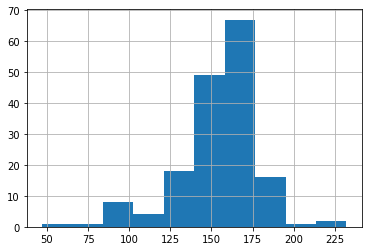

In [64]:
#Length of each comment
movie_reviews_NFLX['critics_consensus'].str.len().hist().plot(kind='bar')
#Graph shows that range is between 175 and 200 characters. So we should use modules which are effective for small document size.


In [65]:
#Number of words in each comment
movie_reviews_NFLX['critics_consensus'].str.split().str.len()


1      23
2      28
3      16
4      24
5      28
       ..
347    23
349    28
350    32
353    24
354    28
Name: critics_consensus, Length: 167, dtype: int64

In [75]:
#Convert Dates from object to datetime
movie_reviews_NFLX[["original_release_date", "streaming_release_date"]] = movie_reviews_NFLX[["original_release_date", "streaming_release_date"]].apply(pd.to_datetime)

##### We will use NLTK, GENSIM, SPACY and TEXTBLOB to do 
Date pre-processing and then check with word cloud the quality and difference in output.

In [77]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))
# Remove Stop Words
movie_reviews_NFLX['critics_consensus_ntext']=movie_reviews_NFLX['critics_consensus'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
movie_reviews_NFLX.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,critics_consensus,original_release_date,streaming_release_date,critics_consensus_ntext,critics_consensus_nltktext,wnltkcount,hnltklength,critics_consensus_spacytext,wspacycount,hspacylength,critics_consensus_gensimtext,wgensimcount,hgensimlength,critics_consensus_txtblbtext,wtxtblbcount,htxtblblength
1,Thanks to director Zak Hilditch's patient stor...,2017-10-20,2017-10-20,thanks director zak hilditch's patient storyte...,thanks director zak hilditch 's patient storyt...,21,136,thank director zak hilditch patient storytelle...,16,113,thanks director zak hilditch 's patient storyt...,21,136,thanks director zak hilditch 's patient storyt...,19,129
2,22 July offers a hard-hitting close-up look at...,2018-10-10,2018-10-10,22 july offers hard-hitting close-up look afte...,22 july offer hard-hitting close-up look after...,20,144,july offer hard hit close look aftereffect ter...,17,121,22 july offer hard-hitting close-up look after...,20,144,22 july offer hard-hitting close-up look after...,18,135
3,37 Seconds is a rare and refreshing film that ...,NaT,2020-01-31,37 seconds rare refreshing film depicts disabi...,37 second rare refreshing film depicts disabil...,13,78,second rare refreshing film depict disability ...,9,68,37 second rare refreshing film depicts disabil...,13,78,37 second rare refresh film depicts disability...,10,69
4,"Delicately sketched but thematically rich, 6 B...",NaT,2018-04-06,"delicately sketched thematically rich, 6 ballo...","delicately sketched thematically rich , 6 ball...",21,148,delicately sketch thematically rich balloon ri...,17,125,"delicately sketched thematically rich , 6 ball...",21,148,delicately sketch thematically rich 6 balloon ...,18,139
5,"6 Underground is loud, frenetic, and finally p...",2019-12-13,2019-12-13,"6 underground loud, frenetic, finally preposte...","6 underground loud , frenetic , finally prepos...",22,134,underground loud frenetic finally preposterous...,14,107,"6 underground loud , frenetic , finally prepos...",22,134,6 underground loud frenetic finally prepostero...,17,121


In [78]:
#NLTK Lemmatization
#Create function to create POS tags to be used for lemmentization.
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
# Lemmatize with POS Tag
from nltk.corpus import wordnet
from collections import Counter
import re
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Complete the tokenizer function
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], get_wordnet_pos(x[1])), nltk_tagged)
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)



# Lemmatizing
# Create a new column after Lemmatization
movie_reviews_NFLX['critics_consensus_nltktext']=movie_reviews_NFLX['critics_consensus_ntext'].apply(lambda x: lemmatize_sentence(x))
movie_reviews_NFLX['critics_consensus_nltktext']=movie_reviews_NFLX['critics_consensus_nltktext'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
#Replace word count with the new text
movie_reviews_NFLX['wnltkcount']=movie_reviews_NFLX['critics_consensus_nltktext'].str.split().str.len()
movie_reviews_NFLX['hnltklength']=movie_reviews_NFLX['critics_consensus_nltktext'].str.len()



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [79]:
#Lemmantization using Spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
allowed_postags = ["NOUN", "ADJ", "VERB", "ADV","PROPN"]



# Lemmatizing
# Create a new column after Lemmatization
movie_reviews_NFLX['critics_consensus_spacytext'] = movie_reviews_NFLX['critics_consensus_ntext'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x) if y.pos_ in allowed_postags]))
#Replace word count with the new headline text
movie_reviews_NFLX['wspacycount']=movie_reviews_NFLX['critics_consensus_spacytext'].str.split().str.len()
movie_reviews_NFLX['hspacylength']=movie_reviews_NFLX['critics_consensus_spacytext'].str.len()



C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-package

C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-package

C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-package

C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-package

In [80]:
#Lemmantization using Gensim
import pattern
from pattern.en import lemma, lexeme
from gensim.utils import lemmatize
movie_reviews_NFLX['critics_consensus_gensimtext']=movie_reviews_NFLX['critics_consensus_ntext'].apply(lambda x: lemmatize_sentence(x))
#Replace word count with the new headline text
movie_reviews_NFLX['wgensimcount']=movie_reviews_NFLX['critics_consensus_gensimtext'].str.split().str.len()
movie_reviews_NFLX['hgensimlength']=movie_reviews_NFLX['critics_consensus_gensimtext'].str.len()



In [81]:
#TextBlob Lemmatizer
from textblob import TextBlob
# Define function to lemmatize each word with its POS tag
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

# Lemmatize
movie_reviews_NFLX['critics_consensus_txtblbtext']=movie_reviews_NFLX['critics_consensus_ntext'].apply(lambda x: lemmatize_with_postag(x))
#Replace word count with the new headline text
movie_reviews_NFLX['wtxtblbcount']=movie_reviews_NFLX['critics_consensus_txtblbtext'].str.split().str.len()
movie_reviews_NFLX['htxtblblength']=movie_reviews_NFLX['critics_consensus_txtblbtext'].str.len()

movie_reviews_NFLX.head()

,critics_consensus,original_release_date,streaming_release_date,critics_consensus_ntext,critics_consensus_nltktext,wnltkcount,hnltklength,critics_consensus_spacytext,wspacycount,hspacylength,critics_consensus_gensimtext,wgensimcount,hgensimlength,critics_consensus_txtblbtext,wtxtblbcount,htxtblblength
1,Thanks to director Zak Hilditch's patient stor...,2017-10-20,2017-10-20,thanks director zak hilditch's patient storyte...,thanks director zak hilditch 's patient storyt...,21,136,thank director zak hilditch patient storytelle...,16,113,thanks director zak hilditch 's patient storyt...,21,136,thanks director zak hilditch 's patient storyt...,19,129
2,22 July offers a hard-hitting close-up look at...,2018-10-10,2018-10-10,22 july offers hard-hitting close-up look afte...,22 july offer hard-hitting close-up look after...,20,144,july offer hard hit close look aftereffect ter...,17,121,22 july offer hard-hitting close-up look after...,20,144,22 july offer hard-hitting close-up look after...,18,135
3,37 Seconds is a rare and refreshing film that ...,NaT,2020-01-31,37 seconds rare refreshing film depicts disabi...,37 second rare refreshing film depicts disabil...,13,78,second rare refreshing film depict disability ...,9,68,37 second rare refreshing film depicts disabil...,13,78,37 second rare refresh film depicts disability...,10,69
4,"Delicately sketched but thematically rich, 6 B...",NaT,2018-04-06,"delicately sketched thematically rich, 6 ballo...","delicately sketched thematically rich , 6 ball...",21,148,delicately sketch thematically rich balloon ri...,17,125,"delicately sketched thematically rich , 6 ball...",21,148,delicately sketch thematically rich 6 balloon ...,18,139
5,"6 Underground is loud, frenetic, and finally p...",2019-12-13,2019-12-13,"6 underground loud, frenetic, finally preposte...","6 underground loud , frenetic , finally prepos...",22,134,underground loud frenetic finally preposterous...,14,107,"6 underground loud , frenetic , finally prepos...",22,134,6 underground loud frenetic finally prepostero...,17,121


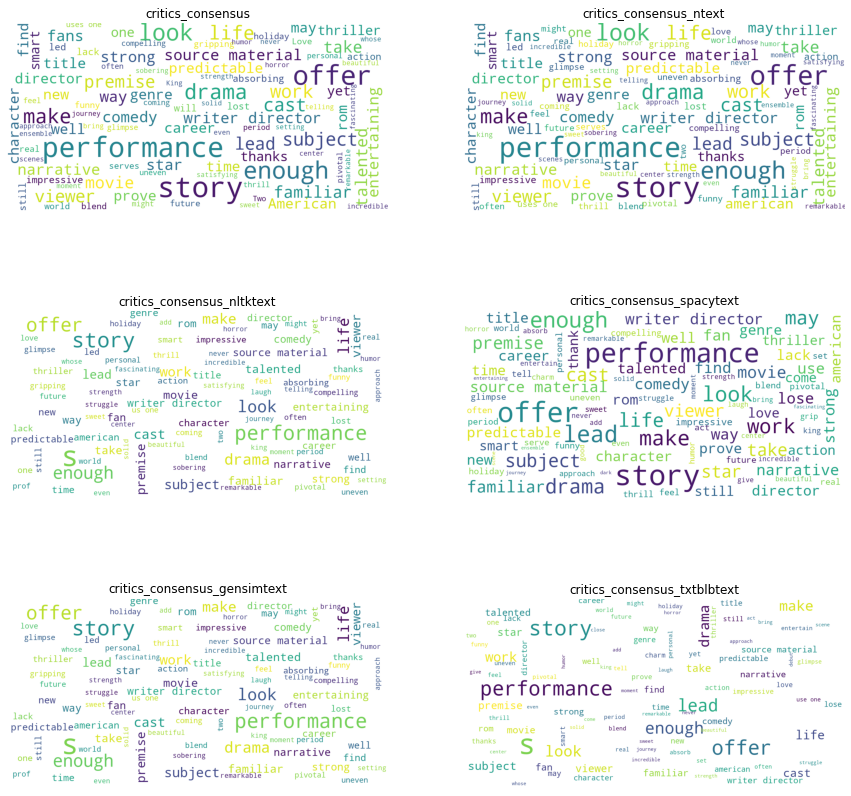

In [83]:
#Word clouds for each of the Lemmatizer

fig = plt.figure(1, figsize=(15, 15))
for i in range(len(movie_reviews_NFLX.columns[movie_reviews_NFLX.dtypes==object])):
    ax = fig.add_subplot( int(len(movie_reviews_NFLX.columns[movie_reviews_NFLX.dtypes==object])/2),2,i+1)
    
    column=movie_reviews_NFLX.columns[movie_reviews_NFLX.dtypes==object][i]
    
    words = ' '.join(movie_reviews_NFLX[column])
    
    wordcloud = WordCloud(
                      background_color='white', 
                      max_words=100,
                      max_font_size=30,
                      scale=3,
                      random_state=1
                     ).generate(words)
    ax.title.set_text(movie_reviews_NFLX.columns[movie_reviews_NFLX.dtypes==object][i])
    ax.imshow(wordcloud)
    ax.axis('off')

In [ ]:
# Obtain Keys to connect to ALPACA API
load_dotenv() # True
CONSUMER_KEY = os.environ.get("ALPACA_API_KEY")

CONSUMER_SECRET_KEY = os.environ.get("ALPACA_SECRET_KEY")
quandl.ApiConfig.api_key = os.environ.get("QUANTA_API_KEY")

In [ ]:
# Initialize ALPACA API
ALPACA_URL='https://paper-api.alpaca.markets'
alpaca_api = tradeapi.REST(CONSUMER_KEY, CONSUMER_SECRET_KEY, ALPACA_URL, api_version='v2')

In [ ]:
# Call ALPACA API to get data for ticker symbols.
# Format current date as ISO format
NY = 'America/New_York'

edate = dt.date.today()
start=pd.Timestamp('2020-08-01', tz=NY).isoformat()
end=pd.Timestamp(edate, tz=NY).isoformat()
# Set the tickers
tickers = ["AGG", "SPY"]
# Set timeframe to '1D' for Alpaca API, 
# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
alpaca_api.get_barset(tickers, '1D', start=start, end=end, limit=1000).df

In [ ]:
#Create dataframe to store API output
alpaca_df=alpaca_api.get_barset(tickers, '1D', start=start, end=end, limit=1000).df